# Benchmark half-life with GO term

This notebook profile the half-lives of genes with different GO term.

In [2]:
import gzip
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [3]:
anno = pd.read_csv(gzip.open("/home/chenzonggui/data/go_term/goa_human.gaf.gz"), comment="!", sep="\t", header=None)
goid2gname = defaultdict(list)
for gname, goid in anno[[2, 4]].values:
    goid2gname[goid].append(gname)

/home/chenzonggui/tmp/ipykernel_14470/2721936201.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  anno = pd.read_csv(gzip.open("/home/chenzonggui/data/go_term/goa_human.gaf.gz"), comment="!", sep="\t", header=None)


In [4]:
def extend(goid):
    for v in relations[goid]:
        yield v
        for v1 in extend(v):
            yield v1
            
def get_gnames(goids):
    gnames = set()
    for goid in goids:
        for gname in goid2gname[goid]:
            gnames.add(gname)
    return gnames

def get_half_life(gnames):
    gnames = list(gnames & set(dat.index))
    return list(dat.loc[gnames]["T"].values)

db = dict()
array = []
with open("/home/chenzonggui/data/go_term/go.obo") as f:
    lines = None
    for line in f:
        line = line.strip("\n")
        if line.startswith("[Term]"):
            lines = []
        elif line == "":
            if lines is not None:
                array.append(lines)
                lines = None
        else:
            if lines is not None:
                lines.append(line)

terms = dict()
relations = defaultdict(list)
for lines in array:
    term = dict()
    for line in lines:
        i = line.find(":")
        k = line[:i]
        v = line[i + 2:]
        if k == "id":
            term[k] = v
        elif k == "name":
            term[k] = v
        elif k == "namespace":
            term[k] = v
        elif k == "def":
            term[k] = v
        elif k == "is_a":
            relations[v.split()[0]].append(term["id"])
    term["lines"] = lines
    terms[term["id"]] = term

In [5]:
for term in terms.values():
    if term["name"] == "regulation of transcription by RNA polymerase II":
        print(term)

{'id': 'GO:0006357', 'name': 'regulation of transcription by RNA polymerase II', 'namespace': 'biological_process', 'def': '"Any process that modulates the frequency, rate or extent of transcription mediated by RNA polymerase II." [GOC:go_curators, GOC:txnOH]', 'lines': ['id: GO:0006357', 'name: regulation of transcription by RNA polymerase II', 'namespace: biological_process', 'alt_id: GO:0006358', 'alt_id: GO:0010551', 'def: "Any process that modulates the frequency, rate or extent of transcription mediated by RNA polymerase II." [GOC:go_curators, GOC:txnOH]', 'synonym: "global transcription regulation from Pol II promoter" RELATED []', 'synonym: "regulation of gene-specific transcription from RNA polymerase II promoter" RELATED []', 'synonym: "regulation of global transcription from Pol II promoter" RELATED []', 'synonym: "regulation of transcription from Pol II promoter" EXACT []', 'synonym: "regulation of transcription from RNA polymerase II promoter" EXACT []', 'synonym: "regulat

In [8]:
dats = []
dat = pd.read_csv("../../1_FLAIRseq/reports/halflife_of_K562_50uM_3h.2TC.tsv", sep="\t", index_col=0)
dat = dat[dat["GeneType"] == "protein_coding"]
dat = dat[dat["Total"] >= 10]
dat["T"] = [max(0.5, min(v, 32)) for v in dat["T"]]
dat = dat[~dat["GeneName"].duplicated()]
dat.index = dat["GeneName"]
dats.append(dat)
dat = pd.read_csv("../../4_RNAseq_ActD/reports/halflife_of_k562_genes.tsv", sep="\t")
dat = dat[dat["GeneType"] == "protein_coding"]
dat = dat[dat["Canonical"]]
dat = dat[~dat["GeneName"].duplicated()]
dat.index = dat["GeneName"]
dat = dat[(dat["FPKM.0h-1"] >= 1) & (dat["FPKM.0h-2"] >= 1) & (dat["R2.Score"] >= 0.8)]
dat["T"] = [max(0.5, min(v, 32)) for v in dat["T"]]
dats.append(dat)

Median half-life: 9.723347660105908
--------------------------------------------------------------------------------
GO:2001141	Transcription	664	3453	1149
T-test of halflife: 1.3966580917978254e-16
T-test of halflife (log2): 6.203688783071163e-25
--------------------------------------------------------------------------------
GO:0009966	Transduction	2343	2945	930
T-test of halflife: 0.14716891785581082
T-test of halflife (log2): 0.1000385892041104
--------------------------------------------------------------------------------
GO:0051726	Cell cycle	2258	1104	576
T-test of halflife: 3.1192641303561433e-09
T-test of halflife (log2): 5.533091669134854e-10
--------------------------------------------------------------------------------
GO:0045595	Differentiation	2485	1529	418
T-test of halflife: 0.0036093702833972607
T-test of halflife (log2): 0.000978049752472374
--------------------------------------------------------------------------------
GO:0004672	Kinases	167	580	198
T-test of half

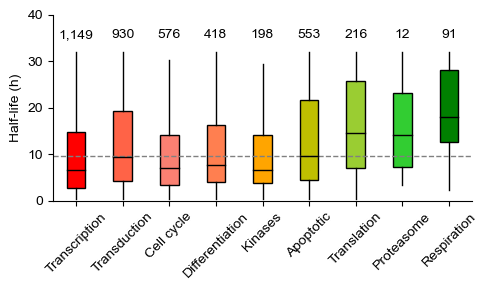

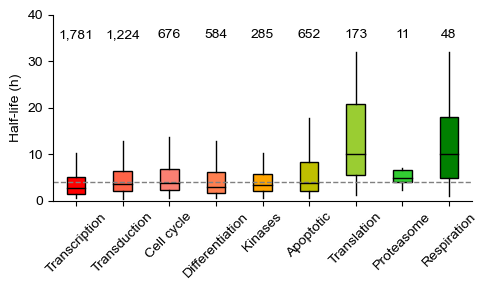

In [9]:
a = {
    "GO:2001141": ["Transcription", "regulation of RNA biosynthetic process"],
    "GO:0009966": ["Transduction", "regulation of signal transduction"],
    "GO:0051726": ["Cell cycle", "regulation of cell cycle"],
    "GO:0045595": ["Differentiation", "regulation of cell differentiation"],
    "GO:0004672": ["Kinases", "protein kinase activity"],
    "GO:0042981": ["Apoptotic", "regulation of apoptotic process"],
    "GO:0006412": ["Translation", "translation"],
    "GO:0043248": ["Proteasome", "proteasome assembly"],
    "GO:0045333": ["Respiration", "cellular respiration"]
}

for name, dat in zip(["FLAIRseq", "ActD"], dats):
    median = np.median(dat["T"])
    print("Median half-life:", median)

    ks = list(a.keys())
    xs = np.arange(len(ks))
    ticks = [a[goid][0] for goid in ks]
    colors = ["red", "tomato", "salmon", "coral", "orange", "y", "yellowgreen", "limegreen", "green"]
    # ys_text = [35, 40, 35, 35, 30, 45, 58, 35, 54]
    plt.figure(figsize=(5, 3))
    for i, goid in enumerate(ks):
        print("-" * 80)
        goids = [goid] + list(extend(goid))
        gnames = get_gnames(goids)
        vs = get_half_life(gnames)
        print(goid, a[goid][0], len(goids), len(gnames), len(vs), sep="\t")
        print("T-test of halflife:", ttest_ind(vs, dat["T"].values)[1])
        print("T-test of halflife (log2):", ttest_ind(np.log2(vs), np.log2(dat["T"]))[1])
        plt.boxplot([vs], positions=[i], showfliers=False, showcaps=False, 
                    widths=0.4, 
                    patch_artist=True, boxprops={"facecolor": colors[i]}, 
                    medianprops={"color": "black"})
        plt.text(i, 35, "%s" % format(len(vs), ","), ha="center")
    plt.axhline(median, lw=1, ls="--", color="grey")
    plt.xticks(xs, ticks, rotation=45)
    plt.xlim(min(xs) - 0.5, max(xs) + 0.5)
    plt.ylim(0, 40)
    # plt.yticks([0, 10, 20, 30, 40, 50, 60])
    plt.xlabel("")
    plt.ylabel("Half-life (h)")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("figures/go_term_halflife.%s.pdf" % name)